### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

<div class="alert alert-success">
<h2> Комментарий ревьюера: Орг. моменты </h2>

Привет, Григорий! Меня зовут Анжела Бурова, и сегодня я твой ревьюер. 

Для начала несколько организационных моментов:
При обнаружении у тебя в работе ошибки, в первый раз я лишь укажу на ее наличие и у тебя будет возможность самому найти её и исправить. В реальной работе твой начальник будет поступать также, а я пытаюсь подготовить тебя именно к работе Дата-инженера. Однако, если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку

По поводу моих комментов:
1. Я буду оставлять комментарии в Markdown-ячейках
2. Эти комментарии не должны удаляться или редактироваться тобой. 
3. На каждый мой комментарий отвечай пожалуйста новой Markdown-ячейкой помечая другим цветом. Можно написать что поправил, или задать вопрос, или объяснить почему сделано так, можно спорить с ревьюером и защищать свою т.з. :)
4. Если я буду обновлять свои комментарии, я буду добавлять v2, v3 и т.д. к заголовку комментария. Тебе предлагаю также соблюдать версионирование комментариев.
5. Можно задавать вопросы и уточнять всё что угодно, если не получается что-то или непонятно.

Комментарии могут быть 3х типов, также как и раньше. 

- Зеленый комментарий с ✔️ (как этот) означает похвалу или развивющие советы.

</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера: Орг. моменты ⚠️</h2>

- Желтый комментарий - рекомендация, можно лучше. Желательно их исправлять, если есть возможность. 

</div>
<div class="alert alert-danger">
<h2> Комментарий ревьюера: Орг. моменты ❌</h2>

- Красный комментарий с критической ошибкой, которую нужно поправить.

</div>

<hr style="border-top: 3px solid purple; "></hr>
Комментарии можешь оставлять с помощью такого кода в Markdown ячейке:
    
    
    <div class="alert alert-info">
    <h2> Комментарий студента</h2>

    Тут текст.
    </div>
    
    
    <font color='red'> Этот код позволяет менять цвет текста. </font>     


  

О том, как форматировать текст в Markdown ячейке или как добавлять ссылки, ты можешь узнать [тут](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet) и [вот тут](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).

<div class="alert alert-warning">
<h2> Комментарий ревьюера: По проекту ⚠️</h2>

У тебя хороший проект, мне очень понравились графики - сделано качественно и красиво) Код тоже на высоте - используешь классы, нет ничего лишнего. молодец!
    
Не хватило мне выводов, оценки модели на тесте и еще есть несколько комментариев, вопросов - посмотри, добавь свои ответы и поправь что можешь)
    
Жду проект после доработок)

</div>

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import psycopg
import mlflow
from dotenv import load_dotenv
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor

In [61]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}

load_dotenv()

TABLE_NAME = 'clean_flats_churn'

postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"), 
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)


with psycopg.connect(**connection) as conn:


    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")

        data = cur.fetchall()

        columns = [col[0] for col in cur.description]


data = pd.DataFrame(data, columns=columns)

In [62]:
RANDOM_STATE = 10

train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

In [63]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "mle-project-sprint-2-v001"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

RUN_NAME = 'baseline'
MODEL_REGISTRY_NAME = 'sprint-2-model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    model_path = '../models/fitted_model.pkl'
    with open(model_path, 'rb') as f:
        model = joblib.load(f)

    mlflow.sklearn.log_model(sk_model=model, artifact_path="pipeline_model", registered_model_name=MODEL_REGISTRY_NAME)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

ASSETS_DIR = "assets"

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [64]:
data.head(10)

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,50968,3,False,9.7,18.900000,1,False,35.000000,10000000.0,1988,4,55.886028,37.658363,2.48,474,16,True
1,50969,11,False,8.4,18.100000,1,False,38.400002,9900000.0,2014,4,55.604900,37.361435,2.75,372,17,True
2,50970,7,False,9.0,33.000000,2,False,53.000000,16500000.0,1970,1,55.829334,37.587299,2.70,112,14,True
3,50971,4,False,8.9,31.299999,2,False,46.900002,14500000.0,1967,6,55.805401,37.572514,2.64,80,12,True
4,50975,12,True,7.0,18.000000,1,False,30.000000,17900000.0,2017,2,55.755783,37.509819,3.00,90,25,True
5,50976,8,False,6.0,30.000000,2,False,46.000000,12300000.0,1967,1,55.793613,37.778828,2.64,108,9,True
6,50978,3,False,10.0,30.000000,2,False,49.000000,20000000.0,1965,1,55.757927,37.573814,2.60,72,9,True
7,50979,8,False,10.0,48.000000,3,False,75.000000,15000000.0,1988,4,55.876789,37.709469,2.64,208,14,True
8,50981,11,False,8.4,17.100000,1,False,38.099998,9400000.0,2008,4,55.550758,37.570644,2.64,195,14,True
9,50982,7,False,14.0,32.900002,2,False,58.000000,14500000.0,2014,2,55.587772,37.456944,2.80,160,9,True


In [65]:
data.nunique()

id                   103493
floor                    20
is_apartment              2
kitchen_area            530
living_area            1347
rooms                     5
studio                    1
total_area             1770
price                  3913
build_year              105
building_type_int         6
latitude              14363
longitude             14007
ceiling_height           35
flats_count             589
floors_total             29
has_elevator              2
dtype: int64

In [66]:
data_info = data.info()

numerical_description = data.describe()

missing_values = data.isnull().sum()

unique_values = data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 103493 non-null  int64  
 1   floor              103493 non-null  int64  
 2   is_apartment       103493 non-null  bool   
 3   kitchen_area       103493 non-null  float64
 4   living_area        103493 non-null  float64
 5   rooms              103493 non-null  int64  
 6   studio             103493 non-null  bool   
 7   total_area         103493 non-null  float64
 8   price              103493 non-null  object 
 9   build_year         103493 non-null  int64  
 10  building_type_int  103493 non-null  int64  
 11  latitude           103493 non-null  float64
 12  longitude          103493 non-null  float64
 13  ceiling_height     103493 non-null  float64
 14  flats_count        103493 non-null  int64  
 15  floors_total       103493 non-null  int64  
 16  ha

In [67]:
data['price'] = data['price'].astype(float)

In [68]:
missing_values, numerical_description, unique_values

(id                   0
 floor                0
 is_apartment         0
 kitchen_area         0
 living_area          0
 rooms                0
 studio               0
 total_area           0
 price                0
 build_year           0
 building_type_int    0
 latitude             0
 longitude            0
 ceiling_height       0
 flats_count          0
 floors_total         0
 has_elevator         0
 dtype: int64,
                   id          floor   kitchen_area    living_area   
 count  103493.000000  103493.000000  103493.000000  103493.000000  \
 mean    68546.243253       6.726039       8.101251      27.533055   
 std     41104.240116       4.508221       2.986849      14.425440   
 min         0.000000       1.000000       0.000000       0.000000   
 25%     32623.000000       3.000000       6.000000      19.000000   
 50%     67293.000000       6.000000       8.400000      28.400000   
 75%    103651.000000       9.000000      10.000000      36.000000   
 max    141361.00

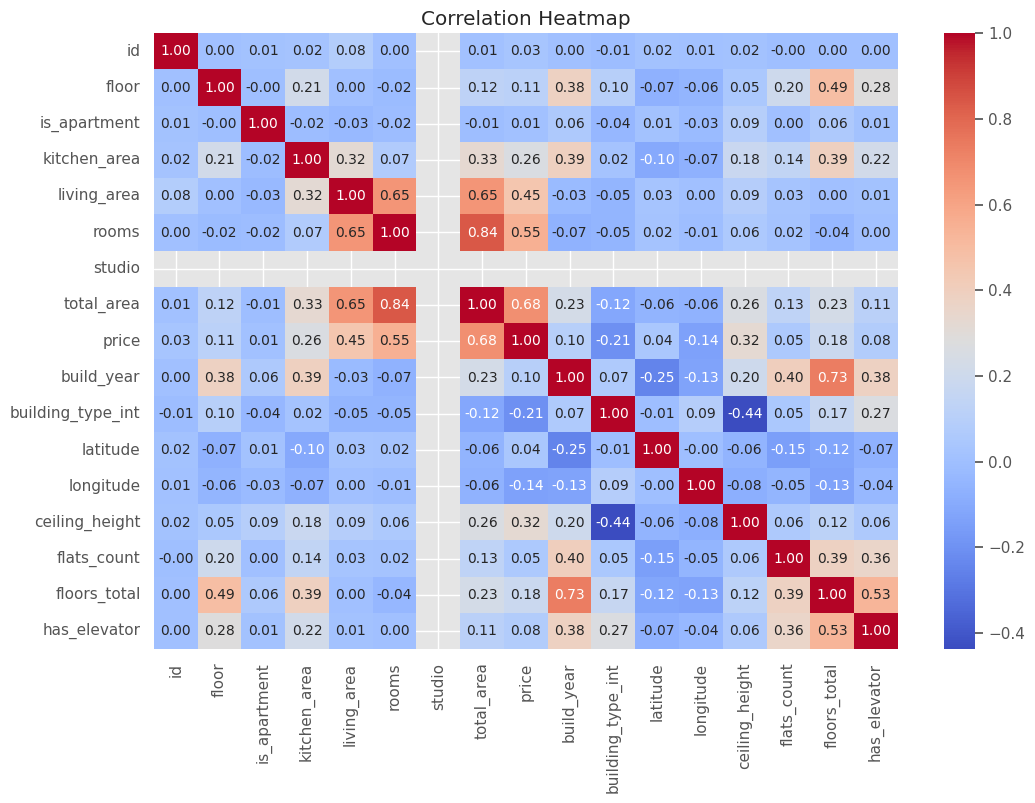

In [69]:
# 2.3 Анализ признаков для модели
plt.style.use('ggplot')

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Отлично! Можно еще построить такую же матрицу по нелинейной корреляции, например phik

</div>


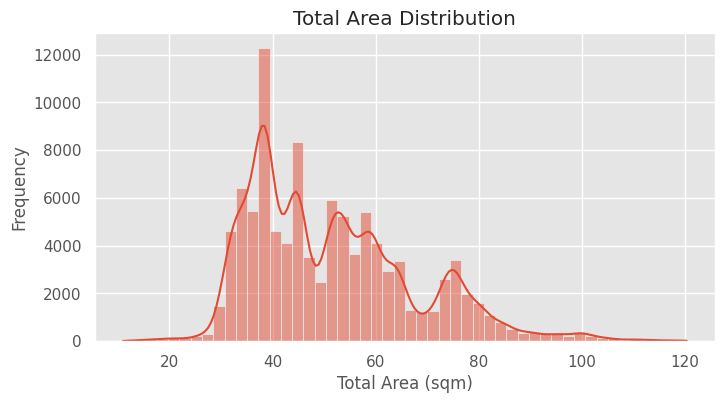

In [70]:
plt.figure(figsize=(8, 4))
sns.histplot(data['total_area'], bins=50, kde=True)
plt.title('Total Area Distribution')
plt.xlabel('Total Area (sqm)')
plt.ylabel('Frequency')
plt.show()

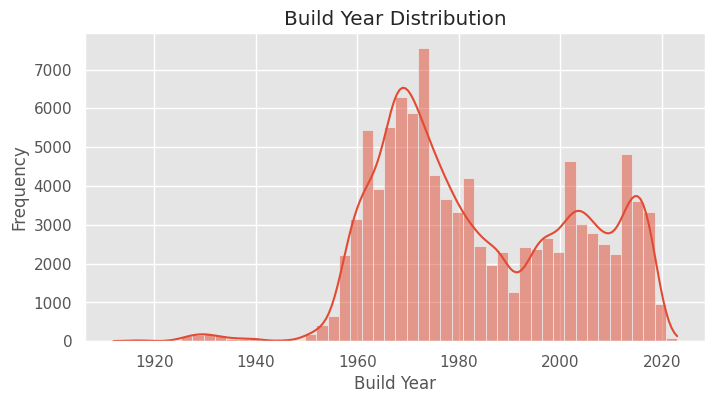

In [71]:
plt.figure(figsize=(8, 4))
sns.histplot(data['build_year'], bins=50, kde=True)
plt.title('Build Year Distribution')
plt.xlabel('Build Year')
plt.ylabel('Frequency')
plt.show()

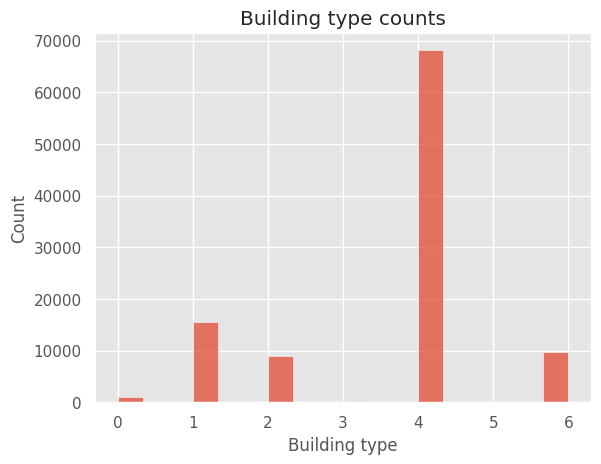

In [72]:
sns.histplot(data['building_type_int'])
plt.title('Building type counts')
plt.xlabel('Building type')
plt.ylabel('Count')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Графики отличные у тебя.  Сделано качественно и информативно!

</div>


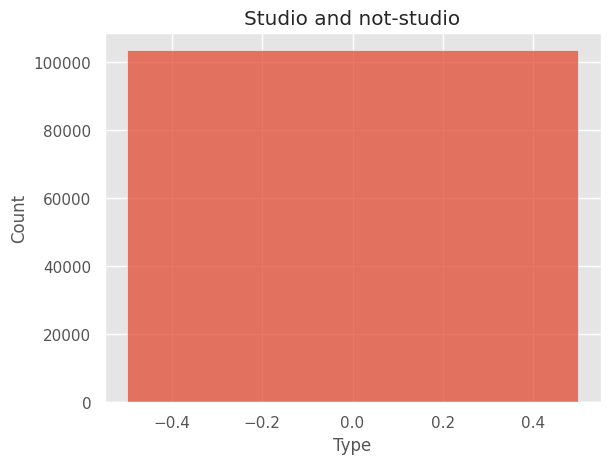

In [73]:
sns.histplot(data['studio'])
plt.title('Studio and not-studio')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

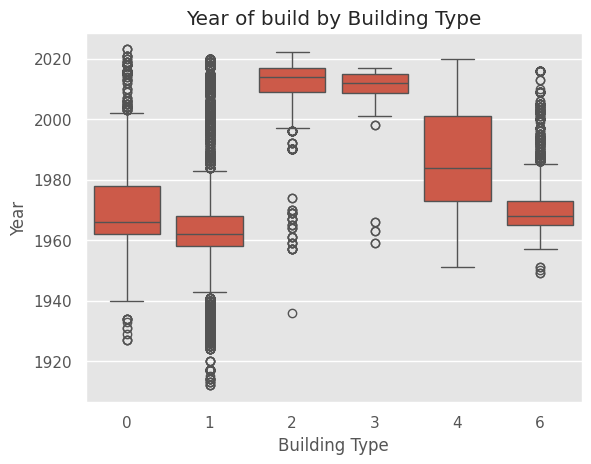

In [74]:
sns.boxplot(x='building_type_int', y='build_year', data=data)
plt.title('Year of build by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Year')
plt.show()

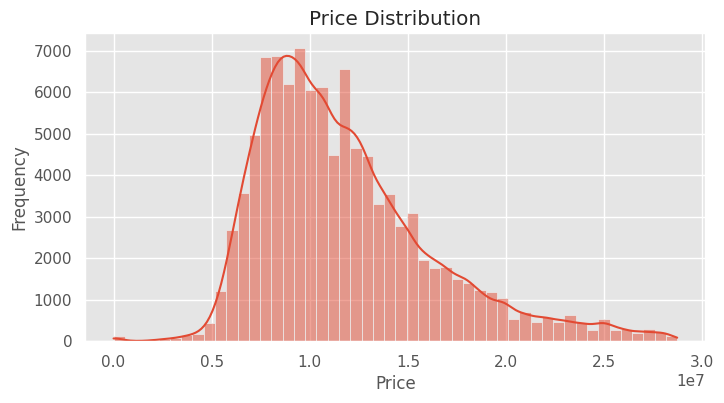

In [75]:
# Анализ целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [76]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

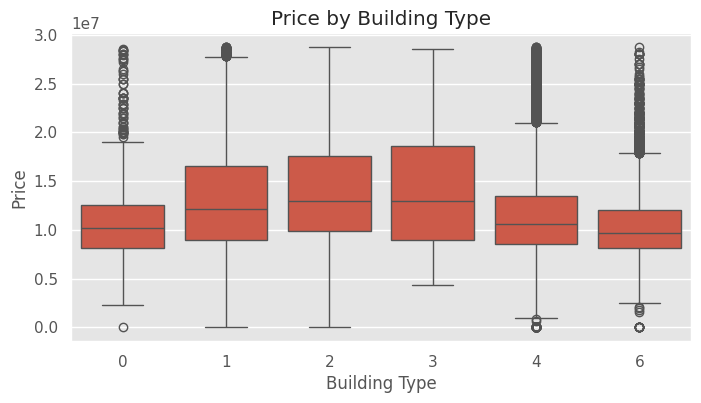

In [77]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='building_type_int', y='price', data=data)
plt.title('Price by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Price')
plt.show()

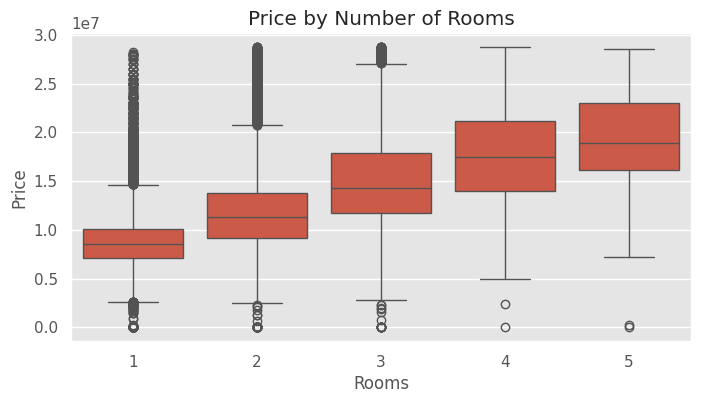

In [78]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='rooms', y='price', data=data)
plt.title('Price by Number of Rooms')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

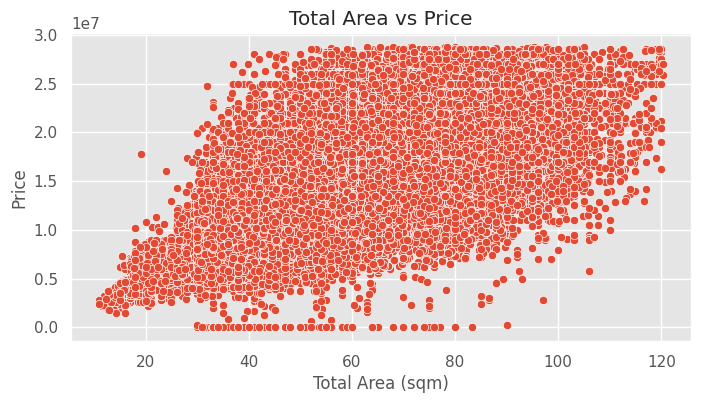

In [79]:

plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_area', y='price', data=data)
plt.title('Total Area vs Price')
plt.xlabel('Total Area (sqm)')
plt.ylabel('Price')
plt.show()

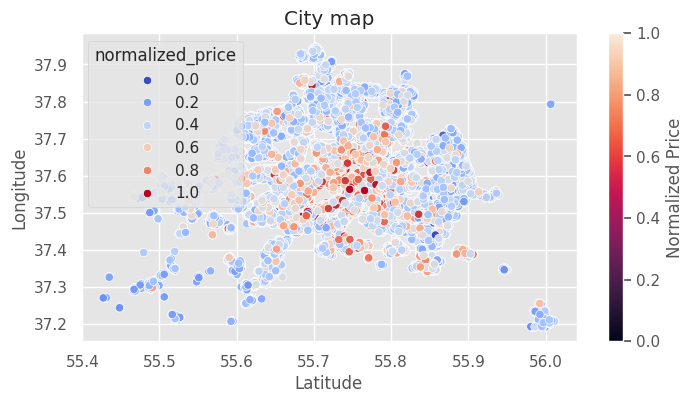

In [80]:
data['normalized_price'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())
plt.figure(figsize=(8, 4))
scatter = sns.scatterplot(x='latitude', y='longitude', hue='normalized_price', palette='coolwarm', data=data)
plt.title('City map')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(scatter.collections[0], label='Normalized Price')
plt.show()
data = data.drop(columns=['normalized_price'])

In [81]:
# 2.5 Выводы после EDA

1. Как и следовало ожидать, цена сильно зависит от общей площади квартиры
2. Поле studio имеет лишь одно уникальное значение, его следует удалить
3. Общая площадь довольно сильно коррелирует с количеством комнат, что может вызвать проблему мультиколлинеарности. Однако, так как изначальной моделью был выбран градиентный бустинг
на основе деревьев решений, это не должно сильно сказаться на качестве модели
4. Присутствует существенный дизбаланс классов в поле building_type, однако градиентный бустинг хорошо справляется с этой проблемой
5. Взаимодействие между общей площадью (total_area) и числом комнат (rooms) может дать лучшее представление о распределении пространства.
6. Соотношение этажа к общему числу этажей может быть индикатором важности расположения квартиры.
7. Возраст здания может влиять на цену квартиры.
8. Расположение квартиры относительно центра города (средних координат) может влиять на цену.

<div class="alert alert-danger">
<h2> Комментарий ревьюера ❌</h2>

 Графиков много, а выводов нет. Выводы здесь - ключевое, самое главное что может увидеть ревьюер. Ведь важно не только уметь строить графики, но делать некие умозаключения на основе их. Весь смысл EDA в том что приняты какие то решения. Добавь пожалуйста выводы
    
</div>

In [82]:
# 2.6 логирование артефактов в MLflow
RUN_NAME = 'eda'
NOTEBOOK_PATH = 'project_template_sprint_2.ipynb'
MARDOWN_PATH = 'conclusions.md'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact(NOTEBOOK_PATH, artifact_path="notebooks")
    mlflow.log_artifact(MARDOWN_PATH, artifact_path="outputs")
    mlflow.log_artifacts(ASSETS_DIR) 
    print(f"Logged run with ID: {run.info.run_id}")

Logged run with ID: 5990f930905a405da41e275bb01029b4


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [83]:
# 3.1 ручная генерация признаков

In [84]:
class CustomFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_longitude = None
        self.mean_latitude = None

    def fit(self, X, y=None):
        self.mean_longitude = 37.6156
        self.mean_latitude = 55.7522
        return self

    def transform(self, X):
        X = X.copy()
        
        X['distance_to_center'] = (X['longitude'] - self.mean_longitude) ** 2 + (X['latitude'] - self.mean_latitude) ** 2
        
        X['space_per_room'] = X['living_area'] / X['rooms']
        
        X['kitchen_total_area'] = X['kitchen_area'] / X['total_area']
        X['living_total_area'] = X['living_area'] / X['total_area']
        
        X['high_floor'] = X['floor'] > (X['floors_total'] / 2)

        X['age'] = 2024 - X['build_year']

        X['flats_density'] = X['flats_count'] / X['floors_total']

        
        return X

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Лучше сделать расстояние до центра города, чем до среднего. Предлагаю тебе понять что это за город и добавить координаты центра. Общая площадь деленная на количество комнат не дает нам площадь на каждую комнату. Общая площадь на то и общеая - вместе с балконами, кухней и т.д. Living_area для этого подходит больше.

В целом доп признаки норм, кроме того что ты плодишь мультиколлинеарность. Если посмотреть на матрицу корреляций - там видно что есть коррелирующие признаки. Ты их соединяешь вместе и добавляешь еще больше мультиколлинеарности, а наша задача наоборот от нее избавиться.

</div>

<div class="alert alert-info">
    <h2> Комментарий студента</h2>

1. Фичи поправил
2. Насколько мне известно, градиентные бустинги не чувствительны к мультиколлинеарности, или, по-крайней мере, в меньшей степени. Могу ошибаться...
</div>

In [85]:
def get_cat_features(data):
    return list(data.nunique()[data.nunique() < 7].index)

def get_num_features(data):
    return [x for x in data.columns if x not in get_cat_features(data) and x != 'price']

In [86]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, cat_features):
        self.feature_names = feature_names
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.feature_names)

        for feature in self.cat_features:
            df[feature] = df[feature].astype(int)
        
        return df

def create_model_pipeline(data, needed_features=[], model_params={'random_state': RANDOM_STATE, 'silent': True}):
    
    preprocessor = Pipeline(steps=[
        ('drop_studio', FunctionTransformer(lambda X: X.drop(columns=['studio', 'id'], errors='ignore'))),
        ('custom_features', CustomFeaturesTransformer())
    ])

    transformed_data = preprocessor.fit_transform(data)
    
    if needed_features:
        num_features = [x for x in get_num_features(pd.DataFrame(transformed_data)) if x in needed_features]
        cat_features = [x for x in get_cat_features(pd.DataFrame(transformed_data)) if x in needed_features]
    else:
        num_features = get_num_features(pd.DataFrame(transformed_data))
        cat_features = get_cat_features(pd.DataFrame(transformed_data))


    column_transformer = ColumnTransformer(transformers=[
            ('ordinal_encoder', OrdinalEncoder(), cat_features),
            ('standard_scaler', StandardScaler(), num_features)],
            remainder='drop')

    full_preprocessor = Pipeline(steps=[
        ('custom_features', preprocessor),
        ('column_transformer', column_transformer),
        ('to_df', ToDataFrameTransformer(feature_names=cat_features + num_features, cat_features=cat_features))
    ])


    model_pipeline = Pipeline(steps=[
        ('preprocessor', full_preprocessor),
        ('regressor', CatBoostRegressor(**model_params, cat_features=cat_features))
    ])

    return model_pipeline

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Мне нравится что ты создаешь доп классы для обработки признаков, это хороший тон.
    
Кроме StandartScaler можно изучить и другие скейлеры: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

</div>


In [94]:
# 3.4 обучение новой версии модели
model_pipeline = create_model_pipeline(train)

metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error']

cv_strategy = KFold(n_splits=3)

cv_res_1 = cross_validate(
    model_pipeline,
    train.drop(columns=['price']),
    train['price'],
    cv=cv_strategy,
    n_jobs=-1,
    scoring=metrics
)

for key, value in cv_res_1.items():
    cv_res_1[key] = round(value.mean(), 3)  

print(cv_res_1)

{'fit_time': 53.208, 'score_time': 0.164, 'test_neg_mean_absolute_error': -1842177.538, 'test_neg_mean_squared_error': -5697957874891.394, 'test_neg_mean_absolute_percentage_error': -10.265}


<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

1. Интересны твои рассуждения, для чего ты делаешь здесь кросс валидацию? Что это тебе дает?
    
2. И убери пожалуйста эти большие выводы ячеек. Они нагружают юпитер и не информативны
    
    
3. Кроме того не увидела у тебя автогенерацию признаков.

</div>

<div class="alert alert-info">
    <h2> Комментарий студента</h2>

1. Кросс валидацию делал по следующим причинам. В начале сделал разбиение на тренировочную и тестовую выборки. Метрики были сильно хуже, чем у baseline модели. Долго пытался понять, в чем же дело, поменял random_state - метрики сильно улучшились. Пришел к выводу, что оценивать модель лучше при помощи кросс-валидации. Итоговую оценку на тестовой выборке добавлю.
2. Выводы ячеек убрал
3. С автогенерацией не придумал, как исключать ненужные автосгенерированные признаки на этапе отбора признаков, ведь вся модель находится в пайплайне. К тому же, автогенерация работала неразумно долго даже для двух функций с двумя шагами, а значительных приростов метрик я не заметил.
</div>

In [96]:
model_pipeline.fit(train.drop(columns=['price']), train['price'])

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f566b5e9fc0>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['is_apartment',
                                                                    'r...
                                                                        'building_type_int',
                                                                        'has_elevator',
                                                                        'high_floor',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'ceiling_height',
                                                                        'flats_count',
                                                                        'floors_total',
                                                                        'distance_to_center',
                                                                        'space_per_room',
                                                                        'kitchen_total_area',
                                                                        'living_total_area',
                                                                        'age',
                                                                        'flats_density']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f5663f20e50>)])

In [97]:
X_val = test.drop(columns=['price'])
y_val = test['price']
y_pred = model_pipeline.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")

MAE: 1828540.452213962
MSE: 5510972146213.488
MAPE: 44.49308151699454


<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Ты не сделал разбиение на трейн и тест, метрики всегда лучше получать на тесте, даже если используется кросс валидация. Обучение финальной модели в продакшне проводится на всем датасете без теста иногда, но это не тот случай, у нас было EDA и стоит оценить не на кросс валидации, а на тесте одном. И срванивать результаты на этом же самом тесте

</div>

In [98]:
# 3.5 логирование артефактов в MLflow
RUN_NAME = 'feature_generation'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('MAPE', mape)
    mlflow.sklearn.log_model(model_pipeline, "model")

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [99]:
preprocessor = model_pipeline.named_steps['preprocessor']

transformed_data = preprocessor.transform(train.drop(columns=['price']))

cat_features = preprocessor.named_steps['column_transformer'].transformers_[0][1].get_feature_names_out()

num_features = preprocessor.named_steps['column_transformer'].transformers_[1][1].get_feature_names_out()

feature_names = np.concatenate([cat_features, num_features])

In [100]:
# 4.1 Отбор признаков при помощи метода номер 1
feature_importances = model_pipeline.named_steps['regressor'].feature_importances_

mean_importance = np.median(feature_importances)

importance_mask = feature_importances > mean_importance

selected_features_1 = feature_names[importance_mask]

selected_features_1

array(['building_type_int', 'kitchen_area', 'total_area', 'build_year',
       'latitude', 'longitude', 'ceiling_height', 'floors_total',
       'distance_to_center', 'age'], dtype=object)

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Для чего нам id в обучении?

</div>

<div class="alert alert-info">
    <h2> Комментарий студента</h2>

Убрал
</div>

In [101]:
# 4.2 Отбор признаков при помощи метода номер 2
from sklearn.inspection import permutation_importance

model_pipeline.fit(train.drop(columns=['price']), train['price'])

regressor = model_pipeline.named_steps['regressor']

results = permutation_importance(regressor, transformed_data, train['price'], n_repeats=5, random_state=RANDOM_STATE)

# Получаем отсортированную важность
sorted_idx = results.importances_mean.argsort()[::-1]
print("Feature ranking:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {results.importances_mean[i]:.3f}")

Feature ranking:
total_area: 0.598
distance_to_center: 0.310
longitude: 0.095
latitude: 0.092
rooms: 0.036
living_area: 0.017
floor: 0.016
build_year: 0.016
kitchen_area: 0.012
age: 0.012
living_total_area: 0.011
ceiling_height: 0.010
building_type_int: 0.010
floors_total: 0.010
space_per_room: 0.009
flats_density: 0.008
flats_count: 0.007
kitchen_total_area: 0.006
is_apartment: 0.001
has_elevator: 0.001
high_floor: 0.001


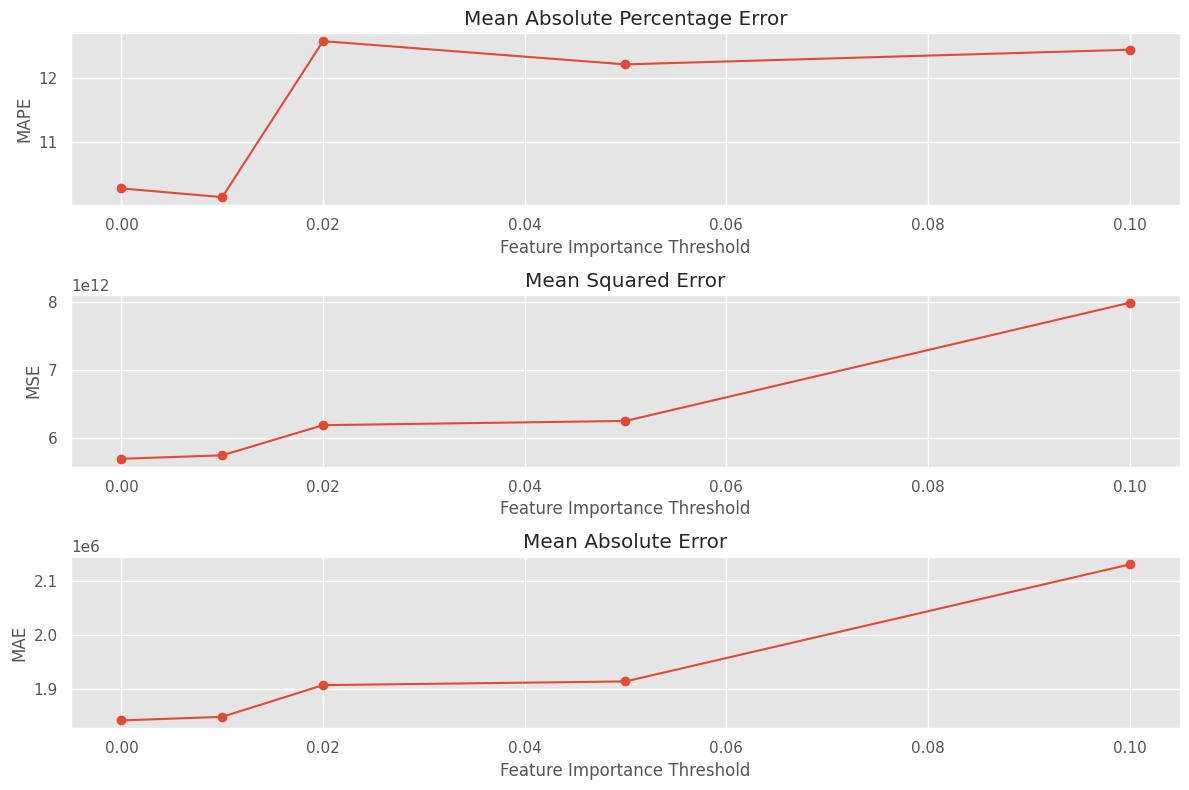

In [102]:
thresholds = np.array([0, 0.01, 0.02, 0.05, 0.1])

mape_scores = []
mse_scores = []
mae_scores = []

metrics = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_absolute_error']

cv_strategy = KFold(n_splits=3)

for threshold in thresholds:

    importance_mask = results.importances_mean >= threshold
    selected_features = list(feature_names[importance_mask])

    model_pipeline = create_model_pipeline(train, selected_features)

    cv_res = cross_validate(
        model_pipeline,
        train.drop(columns=['price']),
        train['price'],
        cv=cv_strategy,
        n_jobs=-1,
        scoring=metrics
    )
    mape_scores.append(-cv_res['test_neg_mean_absolute_percentage_error'].mean())
    mse_scores.append(-cv_res['test_neg_mean_squared_error'].mean())
    mae_scores.append(-cv_res['test_neg_mean_absolute_error'].mean())

plt.figure(figsize=(12, 8))

# График для MAPE
plt.subplot(3, 1, 1)
plt.plot(thresholds, mape_scores, label='MAPE', marker='o')
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MAPE')

# График для MSE
plt.subplot(3, 1, 2)
plt.plot(thresholds, mse_scores, label='MSE', marker='o')
plt.title('Mean Squared Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MSE')

# График для MAE
plt.subplot(3, 1, 3)
plt.plot(thresholds, mae_scores, label='MAE', marker='o')
plt.title('Mean Absolute Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Для чего ты считаешь neg_mse а потом опять переводишь их в обычные? Не проще ли сразу считать mse)

</div>

In [103]:
importance_mask = results.importances_mean >= 0.01
selected_features = list(feature_names[importance_mask])

model_pipeline = create_model_pipeline(train, selected_features)

model_pipeline.fit(train.drop(columns=['price']), train['price'])

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f567829ae60>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['rooms',
                                                                    'building...
                                                                    'age'])])),
                                 ('to_df',
                                  ToDataFrameTransformer(cat_features=['rooms',
                                                                       'building_type_int'],
                                                         feature_names=['rooms',
                                                                        'building_type_int',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'ceiling_height',
                                                                        'distance_to_center',
                                                                        'living_total_area',
                                                                        'age']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f5663f36b90>)])

In [105]:
X_val = test.drop(columns=['price'])
y_val = test['price']
y_pred = model_pipeline.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")

MAE: 1837797.6884633356
MSE: 5567814153229.212
MAPE: 44.153644755909454


In [106]:
# 4.5 Логирование всех артефактов в MLflow

In [107]:
RUN_NAME = 'feature_selection'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_param("selected_features", selected_features)
    mlflow.log_param("importance_threshold", 0.01)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.sklearn.log_model(model_pipeline, "model_after_feature_selection")

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [108]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1


param_dist = {
    'regressor__iterations': [100, 200, 500],
    'regressor__depth': [4, 6, 8, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__l2_leaf_reg': [1, 3, 5, 7],
    'regressor__border_count': [32, 64, 128],
    'regressor__random_strength': [1, 2, 5],
    'regressor__bagging_temperature': [0, 0.5, 1],
    'regressor__silent': [True],
    'regressor__random_state': [RANDOM_STATE]
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='MAPE',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(train.drop(columns=['price']), train['price'])

print(random_search.best_params_)

{'regressor__silent': True, 'regressor__random_strength': 5, 'regressor__random_state': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 100, 'regressor__depth': 8, 'regressor__border_count': 32, 'regressor__bagging_temperature': 0.5}


In [109]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 500]),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'random_strength': trial.suggest_int('random_strength', 1, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_state': RANDOM_STATE,
        'silent': True
    }

    model = create_model_pipeline(train, selected_features, param)
    
    mape = cross_val_score(model, train.drop(columns=['price']), train['price'], 
                           cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    
    return -np.mean(mape)

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20)

print(study.best_trial.params)

[I 2024-10-16 09:25:49,302] A new study created in memory with name: no-name-de35b0de-8518-4a56-9f96-697bdd887f17
[I 2024-10-16 09:26:08,434] Trial 0 finished with value: 10.755502029976903 and parameters: {'iterations': 200, 'depth': 6, 'learning_rate': 0.035897560025186154, 'l2_leaf_reg': 3, 'border_count': 128, 'random_strength': 4, 'bagging_temperature': 0.2517569147714861}. Best is trial 0 with value: 10.755502029976903.
[I 2024-10-16 09:26:32,913] Trial 1 finished with value: 10.559122484065814 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.08001083112034685, 'l2_leaf_reg': 5, 'border_count': 32, 'random_strength': 4, 'bagging_temperature': 0.9772308275427348}. Best is trial 1 with value: 10.559122484065814.
[I 2024-10-16 09:27:35,383] Trial 2 finished with value: 10.939726793340919 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.024911744125379054, 'l2_leaf_reg': 6, 'border_count': 128, 'random_strength': 1, 'bagging_temperature': 0.7108452

{'iterations': 100, 'depth': 10, 'learning_rate': 0.01040292255129962, 'l2_leaf_reg': 3, 'border_count': 128, 'random_strength': 5, 'bagging_temperature': 0.11685284057333786}


In [110]:
# 5.3 Формирование списка гиперпараметров для новой модели
params = study.best_trial.params

In [111]:
# 5.4 Обуение финальной версии модели
model_pipeline = create_model_pipeline(data, selected_features, params)
model_pipeline.fit(train.drop(columns=['price']), train['price'])

0:	learn: 4478542.5954073	total: 53.7ms	remaining: 5.32s
1:	learn: 4454316.8737609	total: 104ms	remaining: 5.08s
2:	learn: 4429474.7329991	total: 153ms	remaining: 4.96s
3:	learn: 4406260.2573276	total: 205ms	remaining: 4.91s
4:	learn: 4384210.0706958	total: 254ms	remaining: 4.82s
5:	learn: 4359680.8971395	total: 309ms	remaining: 4.85s
6:	learn: 4334150.1331463	total: 361ms	remaining: 4.79s
7:	learn: 4311076.3352744	total: 411ms	remaining: 4.72s
8:	learn: 4288356.6079487	total: 460ms	remaining: 4.65s
9:	learn: 4265518.5957725	total: 525ms	remaining: 4.72s
10:	learn: 4242041.8271998	total: 591ms	remaining: 4.78s
11:	learn: 4219088.8776480	total: 640ms	remaining: 4.69s
12:	learn: 4197502.7996905	total: 689ms	remaining: 4.61s
13:	learn: 4177066.5771563	total: 738ms	remaining: 4.54s
14:	learn: 4156859.9344692	total: 789ms	remaining: 4.47s
15:	learn: 4135952.9805626	total: 838ms	remaining: 4.4s
16:	learn: 4114816.6495096	total: 887ms	remaining: 4.33s
17:	learn: 4094036.0635354	total: 940ms	r

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f567829a170>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['rooms',
                                                                    'building...
                                                                    'age'])])),
                                 ('to_df',
                                  ToDataFrameTransformer(cat_features=['rooms',
                                                                       'building_type_int'],
                                                         feature_names=['rooms',
                                                                        'building_type_int',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'ceiling_height',
                                                                        'distance_to_center',
                                                                        'living_total_area',
                                                                        'age']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f566aec3d00>)])

In [112]:
X_val = test.drop(columns=['price'])
y_val = test['price']
y_pred = model_pipeline.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")

MAE: 2342904.2083491283
MSE: 9523727789019.744
MAPE: 52.038472255462146


In [113]:
# 5.5 Логирование артефактов в MLflow
RUN_NAME = 'parameter_tuning'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_params(random_search.best_params_)
    mlflow.log_params(study.best_trial.params)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.sklearn.log_model(model_pipeline, "final_model")

#### <div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Не хватает все таки оценки на тесте, чтобы можно было сравнить результаты всех этапов. Предлагаю тебе добавить графики метрик всех этапов, и выводы о том стало лучше-хуже и почему

</div>